# Introduction

This Jupyter notebook contains the `python` and `R` code for running the analysis in:

    Conflict, Cheap Talk, and Jespersen's Cycle. Christopher Ahern and Robin Clark. 2106

Here is some relevant system and version information. Using the `Anaconda` python distribution is highly recommended for installing and configuring the `SciPy` stack and other dependencies.

In [1]:
import IPython
import sys
import numpy as np
import scipy
print 'Python version: ', sys.version
print 'Platform: ', sys.platform
print
print 'IPython version: ', IPython.__version__
print 'NumPy version: ', np.__version__
print 'SciPy version: ', scipy.__version__

Python version:  2.7.11 |Anaconda 2.4.0 (x86_64)| (default, Dec  6 2015, 18:57:58) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Platform:  darwin

IPython version:  4.0.0
NumPy version:  1.10.4
SciPy version:  0.17.0


# 4. Equilibria

In [50]:
from scipy.stats import beta, uniform
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
hfont = {'fontname':'Times New Roman'}

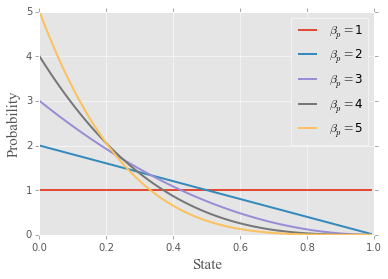

In [51]:
x = np.arange (0, 1, 0.01)

plt.style.use('ggplot')
for beta_var in range(1,6):
        y = beta.pdf(x,1,beta_var)
        plt.plot(x,y, label=r'$\beta_p = $' + str(beta_var), linewidth=2)
plt.legend(loc='upper right')
plt.ylabel("Probability", fontsize=15, **hfont)
plt.xlabel("State", fontsize=15, **hfont)
plt.savefig('../local/out/beta-distribution.pdf', format='pdf', dpi=1000)
plt.show()

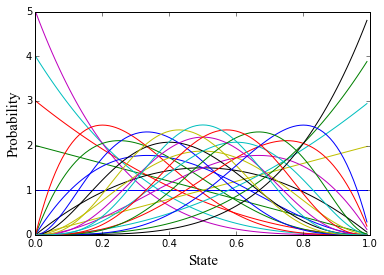

In [7]:
from scipy.stats import beta, uniform
import numpy as np
x = np.arange (0, 1, 0.01)

for alpha_var in range(1,6):
    for beta_var in range(1,6):
        y = beta.pdf(x,alpha_var,beta_var)
        plt.plot(x,y)
plt.ylabel("Probability", fontsize=15, **hfont)
plt.xlabel("State", fontsize=15, **hfont)
plt.show()

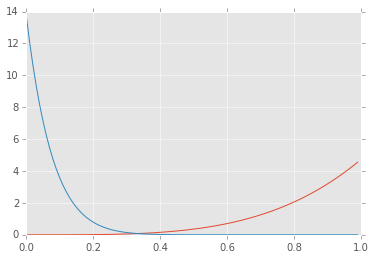

In [45]:
x = np.arange (0, 1, 0.01)

plt.style.use('ggplot')
y = beta.pdf(x, 4.728, 1)
plt.plot(x,y)
y = beta.pdf(x, 1, 13.793)
plt.plot(x,y)
plt.show()

## Calculating evolutionarily stable strategies of the signaling game

First, we import `sympy`, which is a library for symbolic math.

In [8]:
from sympy import *
from sympy.stats import Beta, density

Next, we define the symbols that we'll use in constructing the utility functions and the prior probability.

In [9]:
t, t_0, m_0, m_1, a_0, a_1, b = symbols('t t_0 m_0 m_1 a_0 a_1 b')
T = Beta("t", 1, 2)

Then, we build the actual utility functions and the respective expected utilities. Note that we can save a bit of effort by noting that the speaker's utility is defined by the hearer's response and the hearer's utility is the speaker's where $b=0$.

In [10]:
Utility_S_0 = 1 - (a_0 - t - (1-t)*b)**2
Utility_S_1 = 1 - (a_1 - t - (1-t)*b)**2
E_Utility_S = integrate(Utility_S_0*density(T)(t).evalf(), (t, 0, t_0)) + \
                integrate(Utility_S_1*density(T)(t).evalf(), (t, t_0, 1))
E_Utility_R = E_Utility_S.subs(b, 0)

Now, we can differentiate the utility functions by the actions available to speakers and hearers, and solve for the values of $t_0, a_0, a_1$ that maximize the expected utilities.

In [11]:
t0_sol = Eq(solve(diff(E_Utility_S, t_0), t_0)[0], t_0)
a0_sol = Eq(solve(diff(E_Utility_R, a_0), a_0)[0], a_0)
a1_sol = Eq(solve(diff(E_Utility_R, a_1), a_1)[0], a_1)

This can take a bit of time, so by default we've supplied the set of solutions to this system of equations. Note that there are two solutions because we haven't supplied the information to the solver that the values are constrained to be positive. In fact, we are only interested in the second solution that yields an ESS.

In [12]:
# %time ESS = solve([t0_sol, a0_sol, a1_sol], [t_0, a_0, a_1])

In [13]:
ESS = [((9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0), 0.333333333333333*(-3.0 + 2.0*(9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0))*(9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/((-2.0 + (9.0*b - (9.0*b**2 - 18.0*b + 5.0)**0.5 - 3.0)/(6.0*b - 2.0))*(6.0*b - 2.0)), 0.333333333333333 + 0.666666666666667*(9.0*b - sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0)), ((9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0), 0.333333333333333*(-3.0 + 2.0*(9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0))*(9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/((-2.0 + (9.0*b + (9.0*b**2 - 18.0*b + 5.0)**0.5 - 3.0)/(6.0*b - 2.0))*(6.0*b - 2.0)), 0.333333333333333 + 0.666666666666667*(9.0*b + sqrt(9.0*b**2 - 18.0*b + 5.0) - 3.0)/(6.0*b - 2.0))]

We can visualize this result in the following manner.

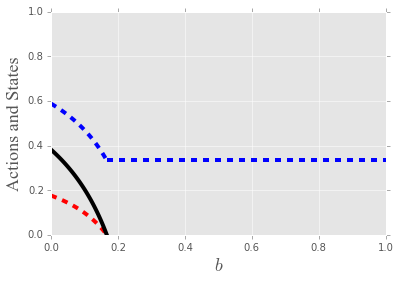

In [14]:
x = np.linspace(0,1/6.0, num=100)
plt.style.use('ggplot')
plt.plot(x, [ESS[1][1].subs(b, value).evalf() for value in x], 'r', linewidth=4, linestyle='--')
plt.plot(x, [ESS[1][2].subs(b, value).evalf() for value in x], 'b', linewidth=4, linestyle='--')
plt.plot(x, [ESS[1][0].subs(b, value).evalf() for value in x], 'k', linewidth=4)
plt.axhline(1/3.0, 1/6.0, 1, color='b', linewidth=4, ls='--')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel(r"$b$", fontsize=18, **hfont)
plt.ylabel(r"Actions and States", fontsize=18, **hfont)
plt.savefig("../local/out/ESS-beta.pdf", format='pdf', dpi=1000, fontsize=18)
plt.show()

We can find the values of the variables for a given value of $b$. For example, for $b=0$, we can do the following.

In [ ]:
[item.subs(b, 0).evalf() for item in ESS[1]]

Next, we can solve for the degree of speaker bias that will lead to the use of a single message. That is, if $b > \frac{1}{6}$, then only $ne...not$ will be used.

In [ ]:
solve(ESS[1][0], b)[0]

# 5. Dynamics

# Fitting the dynamic model to historical corpus data

In [15]:
%load_ext rpy2.ipython

In [16]:
%%R
library(ggplot2, warn.conflicts=F, quietly=T)
library(dplyr, warn.conflicts=F, quietly=T)
library(extrafont)
library(reshape2, quietly=T)
neg.data.full = read.csv("../data/digs15-negative-priming/data/neg-data.csv", header=T)
neg.data.full = tbl_df(neg.data.full)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Registering fonts with R

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [17]:
%%R
# Filter out tokens without do-support label, year, or type
excluded.texts = c("CMORM","CMBOETH","CMNTEST","CMOTEST")
# CMBOETH : translation of Boethius' "Consolation of Philosophy", which is notably stilted
# CMORM   : Ormulum is very specific poetic format where adding an additional syllable for the meter is required
# CMOTEST, CMNTEST : Old and new testaments, which are known to carry archaisms longer than other texts
neg.data = neg.data.full %>% 
            filter(finite != "-") %>% # Exclude non-finite clauses
            filter(clausetype != "imperative") %>% # Exclude imperatives
            filter(exclude != "only") %>% # Exclude focus constructions
            filter(exclude != "constituent") %>% # Exclude constituent negation
            filter(exclude != "contraction") %>% # Exclude contraction
            filter(exclude != "coordination") %>% # Exclude coordinated clauses
            filter(exclude != "concord") %>% # Exclude cases of negative concord
            filter(exclude != "X") %>% # Exclude corpus errors
            filter(! author %in% excluded.texts) %>% # Exclude texts
            mutate(stages = ifelse(has.both, 2, ifelse(has.ne, 1, 3))) %>%
            select(year, author, stages)

In [18]:
%%R
#neg.data = neg.data.full %>% filter(! author %in% excluded.texts)
neg.plot.data =  neg.data %>% group_by(year, author) %>% 
    summarize(total=n(), ne=sum(stages==1, na.rm=TRUE)/total,
              not=sum(stages==3, na.rm=TRUE)/total,
              ne.not=sum(stages==2, na.rm=TRUE)/total)
neg.plot.data = melt(neg.plot.data, id=c("year", 'author', "total"))

ggplot(neg.plot.data, aes(x = year, y = value, color = variable)) +
  geom_point(aes(size = total), alpha = 0.5) +
  geom_smooth(method="loess", se = F, size=4) + # aes(weight = total), span=.6,
  scale_x_continuous(name="Year", limits=c(1100, 1500)) +
  scale_y_continuous(name="Proportion of forms", breaks=seq(0,1,.25)) +   scale_size_area("N", max_size = 20) +
  theme(text = element_text(size=20, family="Times New Roman"), legend.position="none") +  
  coord_cartesian(ylim = c(-.1,1.1)) #+ theme_hc()
ggsave('../local/out/neg-year-lines.pdf', height=6, width=8)

In [19]:
%%R
# Compare ne to ne...not and not
first.data = neg.data %>% group_by(year) %>% mutate(value = as.integer(! stages==1)) %>% select(year, author, value)
first.plot.data = first.data %>% group_by(year, author) %>% 
    summarize(p = sum(value)/n(), total=n())
ggplot(aes(x = year, y = p), data = first.plot.data) +
  geom_point(aes(size = total), alpha = 0.5, position = "identity") +
  geom_smooth(method="loess", se = F, size=4) + 
  scale_x_continuous(name="Year", limits=c(1100, 1500)) +   
  scale_y_continuous(name="Proportion of forms", breaks=seq(0,1,.25)) +
  theme(text = element_text(size=20, family="Times New Roman")) + theme(legend.position="none") +
  scale_size_area("N", max_size = 20) +  coord_cartesian(xlim = c(1090,1540)) + coord_cartesian(ylim = c(-.1,1.1))
ggsave('../local/out/lump-plot1.pdf', height=6, width=8)

In [20]:
%%R
functional.cycle.data = data.frame(year=rep(0, 401), has.tokens=rep(0,401), ones=rep(0, 401), zeros=rep(0, 401))
for (i in c(0:401)) {
    functional.cycle.data$year[i] = i + 1100 - 1
    functional.cycle.data$has.tokens[i] = nrow(first.data %>% filter(year == i + 1100 - 1)) > 0
    functional.cycle.data$ones[i] = nrow(first.data %>% filter(year == i + 1100 - 1, value == 1))
    functional.cycle.data$zeros[i] = nrow(first.data %>% filter(year == i + 1100 - 1, value == 0))
}
write.csv(functional.cycle.data, "functional-cycle-data.csv", row.names=F)

## Defining the evolutionary game dynamics

In [21]:
import pandas as pd
import numpy as np

In [22]:
func_data = pd.read_csv('functional-cycle-data.csv')

Next, we define the discrete-time behavioral replicator dynamics outlined in Huttegger and Hofbauer (2015). The basic intuition is that we treat each state and each message *as if* it were its own population. This reduces calculating the dynamics to matrix multiplication.

In [23]:
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.special import beta as beta_func
from scipy.misc import comb
def beta_binomial(n, alpha, beta):
    return np.matrix([comb(n-1,k) * beta_func(k+alpha, n-1-k+beta) / beta_func(alpha,beta) for k in range(n)])
def beta_binomial_expectation(prior):
    return sum([prior[i]*i/len(prior) for i in range(len(prior))])

In [24]:
def U_S(state, action, b):
    return 1 - (action - state - (1-state)*b)**2
    #return 1 - abs(action - state - (1-state)*b)
def U_R(state, action):
    return 1 - (action - state)**2
# Define functions to map integers to interval [0,1]
def t(i, n):
    return i/float(n)
def a(i, n):
    return i/float(n)

In [25]:
def discrete_time_replicator_dynamics(n_steps, X, Y, A, B, P):
    """Calculate the discrete-time replicator dynamics for"""
    # Get the number of states, signals, and actions
    X_nrow = X.shape[0]
    X_ncol = X.shape[1]
    Y_nrow = Y.shape[0] # Same as X_ncol
    Y_ncol = Y.shape[1] # Often, but not necessarily, the same as X_nrow
    # Create empty arrays to hold the population states over time
    X_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    Y_t = np.empty(shape=(n_steps, X_nrow*X_ncol), dtype=float)
    # Set the initial state
    X_t[0,:] = X.ravel()
    Y_t[0,:] = Y.ravel()
    # Iterate forward over (n-1) steps
    for i in range(1,n_steps):
        # Get the previous state
        X_prev = X_t[i-1,:].reshape(X_nrow, X_ncol)
        Y_prev = Y_t[i-1,:].reshape(Y_nrow, Y_ncol)
        # Calculate the scaling factors
        E_X = A * Y_prev.T
        X_bar = (((A * Y_prev.T) * X_prev.T).diagonal()).T
        X_hat = E_X / X_bar
        # 
        C = np.divide(np.multiply(P.T, X_prev), (P * X_prev)[0])
        E_Y = (B.T * C).T
        Y_bar = ((E_Y*Y_prev.T).diagonal()).T
        Y_hat = np.divide(E_Y, Y_bar)
        # Calculate next states
        X_t[i,:] = np.multiply(X_prev, X_hat).ravel()
        Y_t[i,:] = np.multiply(Y_prev, Y_hat).ravel()
    return X_t, Y_t

In [26]:
def simulate_dynamics(n_steps, params):
    # Unpack the paramters
    a_x = params[0] # Sender initial state parameter
    b_y1 = 1 #params[1] # Receiver response to m1 parameter
    b_y2 = 1 # params[2] # Receiver response to m2 parameter
    b_p = params[1] # params[3]
    b = params[2] # params[4] # Sender bias parameter
    k = max(1, np.floor(params[3])) # int(params[5]) # Change this to alter scaling parameter
    # Construct initial states
    # Number of states and actions
    number = 100
    # Define prior probability
    prior = beta_binomial(number, 1, b_p)
    P = np.repeat(prior, 2, axis=0)
    # Define payoff matrices
    A =  np.matrix([[U_S(t(i, number-1), a(j,number-1), b) for j in range(number)] for i in range(number)])
    B = np.matrix([[U_R(t(i, number-1), a(j,number-1)) for j in range(number)] for i in range(number)])
    # Define sender population
    X0_m2 = beta_binomial(number, a_x, 1)
    X0_m1 = 1 - X0_m2
    X0 = np.vstack((X0_m1, X0_m2)).T
    # Calculate expected state given m2
    p_ti_m2 = np.multiply(X0[:,1], prior.T)
    p_m2 = prior * X0[:,1]
    p_t_m2 = p_ti_m2 / p_m2
    E_t_m2 = (np.array(range(number)) * p_t_m2) / number
    scale = E_t_m2[0,0]/(1 - E_t_m2[0,0])
    # Define receiver population
    Y0 = np.vstack((beta_binomial(number, (1/float(b_p))*b_y1, b_y1), beta_binomial(number, scale*b_y2, b_y2)))
    # Iterate through the discrete-time replicator dynamics
    X_sol, Y_sol = discrete_time_replicator_dynamics(n_steps*int(k), X0, Y0, A, B, P)
    return X_sol[0::k,:], Y_sol[0::k,:], prior

In [27]:
def calc_LL(p, df):
    return np.dot(np.log(p), df.ones) + np.dot(np.log(1 - p), df.zeros)

In [28]:
def loss_function(params, df):
    # Simulate the dynamics from 1100 to 1500
    X_sol, Y_sol, prior = simulate_dynamics(401, params)
    # Get p(m_2) over time
    m2_sol = np.asarray([prior.dot(line)[0,0] for line in X_sol[:,1::2]])
    # Calculate log likelihood given m2_sol
    LL = calc_LL(m2_sol, df)
    return -1*LL # Minimizing negative log-likelihood is equivalent to maximizing log-likelihood

In [29]:
from functools import partial
f = partial(loss_function, df=func_data)

In [30]:
import pickle

In [33]:
%%time
fit = minimize(f, method="L-BFGS-B",
              x0=np.array([5, 10, 1/6.0, 1]),
              bounds=((1, 100), (1, 100), (0,1), (1,10)),
              options={"maxiter" : 1000, "disp" : True})

with open('fit.pickle', 'wb') as handle:
    pickle.dump(fit, handle)

CPU times: user 16.1 s, sys: 92.1 ms, total: 16.2 s
Wall time: 16.3 s


In [47]:
states = np.linspace(0,1, num=100)
timesteps=400
# Get states from X_sol or Y_sol
def plot_m2(X_sol, Y_sol, prior):
    plt.style.use('ggplot')

    #plt.subplot('111', axisbg='.95')
    #plt.grid(b=False, which='major', color='w', linestyle='-', zorder=0)
    m2_sol = [prior.dot(line)[0,0] for line in X_sol[:,1::2]]
    years = [1100 + item for item in range(400)]
    plt.plot(years, m2_sol, 'b', linewidth=4, zorder=3)
    plt.ylim(-.1,1.1)
    plt.xlim(1075, 1525)
    plt.xlabel('Year', fontsize=18, **hfont)
    plt.yticks(np.linspace(0, 1, num=5))
    plt.ylabel(r'$p(m_{ne...not})$', fontsize=18)
    #plt.text(1150, .7, r'$\hat{b} = $' + " " + "%.3f" % b_fit, fontsize=18, **hfont)
    plt.savefig("../local/out/p-m2.pdf", format='pdf', dpi=1000)
    plt.show()
    
def plot_t_m2(X_sol, Y_sol, prior):
    for j, i in enumerate(range(0,timesteps, timesteps/4)):
        p_ti_m2 = np.multiply(X_sol[i,1::2], prior)
        p_m2 =  X_sol[i,1::2] * prior.T
        p_t_m2 = p_ti_m2 / p_m2
        plt.plot(states, p_t_m2.tolist()[0], color='b', linewidth=4-j, alpha=(1 - .5*(i/float(timesteps))))
    plt.text(.3, .04, str(1100) + " CE", fontsize=18, **hfont)
    plt.text(.2, .08, str(1200) + " CE", fontsize=18, **hfont)
    plt.text(.08, .1, str(1300) + " CE", fontsize=18, **hfont)
    plt.text(.02, .12, str(1400) + " CE", fontsize=18, **hfont)    
    plt.plot(states, prior.tolist()[0], 'k--')
    plt.ylabel(r'$p(t \mid m_{ne...not})$', fontsize=18)
    plt.xlabel('States', fontsize=18, **hfont)
    plt.savefig("../local/out/pt-m2.pdf", format='pdf', dpi=1000)
    plt.show()

def plot_t_m1(X_sol, Y_sol, prior):
    for j, i in enumerate(range(0,timesteps, timesteps/4)):
        p_ti_m1 = np.multiply(X_sol[i,0::2], prior)
        p_m1 =  X_sol[i,0::2] * prior.T
        p_t_m1 = p_ti_m1 / p_m1
        plt.plot(states, p_t_m1.tolist()[0], color='r', linewidth=4-j, alpha=(1 - (1/float(timesteps))))
    plt.plot(states, prior.tolist()[0], 'k--')
    plt.ylabel(r'$p(t \mid m_{ne})$', fontsize=18)
    plt.xlabel('States', fontsize=18, **hfont)
    plt.savefig("../local/out/pt-m1.pdf", format='pdf', dpi=1000)
    plt.show()

def plot_a1(X_sol, Y_sol, prior):
    for i in range(0,timesteps, timesteps/4):
        plt.plot(states, Y_sol[i,:100], color='r', alpha=(i/float(timesteps)))
    #plt.plot(states, Y_sol[0,:200], 'r--')
    plt.plot(states, Y_sol[-1,:100], 'r', linewidth=4)
    plt.ylabel(r'$p(a_1)$', fontsize=15, **hfont)
    plt.xlabel('Actions', fontsize=15, **hfont)
    plt.show()

def plot_a2(X_sol, Y_sol, prior):
    for i in range(0,timesteps, timesteps/4):
        plt.plot(states, Y_sol[i,100:], color='b', alpha=(i/float(timesteps)))
    #plt.plot(states, Y_sol[0,200:], 'b--')
    plt.plot(states, Y_sol[-1,100:], 'b', linewidth=4)
    plt.ylabel(r'$p(a_2)$', fontsize=15, **hfont)
    plt.xlabel('Actions', fontsize=15, **hfont)
    plt.show()

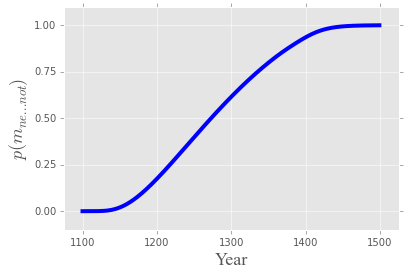

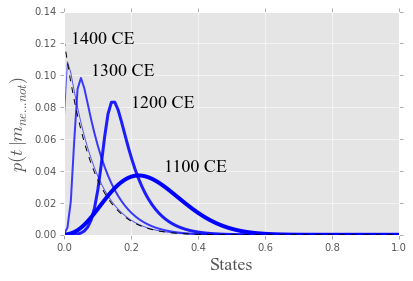

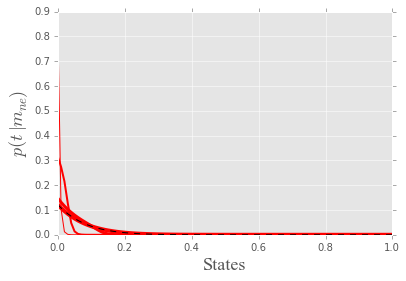

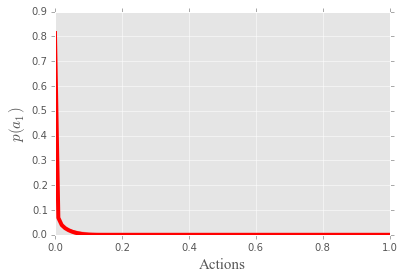

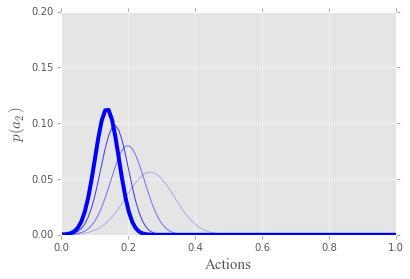

In [48]:
X_sol, Y_sol, prior = simulate_dynamics(400, fit.x)
plot_m2(X_sol, Y_sol, prior)
plot_t_m2(X_sol, Y_sol, prior)
plot_t_m1(X_sol, Y_sol, prior)
plot_a1(X_sol, Y_sol, prior)
plot_a2(X_sol, Y_sol, prior)

In [ ]:
fit_dict = {}
for i in range(1,6):
    try:
        fit_dict[i] = minimize(f, method="L-BFGS-B",
                  x0=np.array([5, 10, 1/6.0, i]),
                  bounds=((1, 100), (1, 100), (0,1), (1,10)),
                  options={"maxiter" : 1000, "disp" : True})
    except:
        pass

with open('fit_dict.pickle', 'wb') as handle:
    pickle.dump(fit_dict, handle)

In [46]:
plt.plot(fit_dict.keys(), [item.fun for item in fit_dict.values()], 'ko--')
plt.show()
plt.plot(fit_dict.keys(), [item.x[1] for item in fit_dict.values()], 'ko--')
plt.ylim(1, 100)
plt.show()
plt.plot(fit_dict.keys(), [item.x[2] for item in fit_dict.values()], 'ko--')
plt.ylim(0,1)
plt.show()

NameError: name 'fit_dict' is not defined

As a point of comparison, we can test out other methods.

In [ ]:
%%time
fit_TNC_dict = {}
for i in range(1,6):
    fit_TNC_dict[i] = minimize(f, method="TNC",
                  x0=np.array([5, 10, 1/6.0, i]),
                  bounds=((1, 100), (1, 100), (0,1), (1,10)),
                  options={"maxiter" : 1000, "disp" : True})
with open('fit_TNC_dict.pickle', 'wb') as handle:
    pickle.dump(fit_TNC_dict, handle)

In [ ]:
plt.plot(fit_TNC_dict.keys(), [item.fun for item in fit_TNC_dict.values()], 'ko--')
plt.show()
plt.plot(fit_TNC_dict.keys(), [item.x[1] for item in fit_TNC_dict.values()], 'ko--')
plt.ylim(1, 100)
plt.show()
plt.plot(fit_TNC_dict.keys(), [item.x[2] for item in fit_TNC_dict.values()], 'ko--')
plt.ylim(0,1)
plt.show()